# Performance over time (and comparison with other reservoirs)
In previous experiments, we note that model performance in testing is much worse than in training or even validation. 

## Shasta data distribution
Here, we compare the distributions (CDF) for the input hydrology and the output releases for the train (60%), validation (20%), and test (20%) datsets. 

In [1]:
import os
print(f'Old working directory: {os.getcwd()}')
# change directory out of subdirectory 'experiments'
os.chdir('..')
print(f'Current working directory: {os.getcwd()}')

Old working directory: c:\Users\mattc\Documents\DL-reservoir-modeling\experiments
Current working directory: c:\Users\mattc\Documents\DL-reservoir-modeling


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

In [3]:
from src.data.data_processing import *
from src.data.data_fetching import *

In [4]:
# Read in data, columns are [inflow, outflow, storage]
df = usbr_fetch_data(name='Shasta', vars=['inflow', 'outflow', 'storage'])
# Select data window (beginning of 1944 to end of 2022)
df = df['1944-01-01':'2022-12-31'].copy()
# Remove na
df = df.dropna(how='any')
data = df.values

In [5]:
# Split the data into train/validation/test sets
data_train, data_val, data_test = train_val_test(data=data, train_frac=0.6, val_frac=0.2, test_frac=0.2)

### Compare hydrology (inflow) CDF's

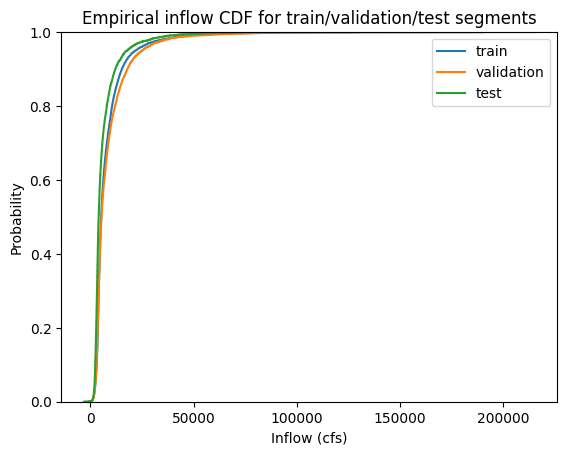

In [6]:
fig, ax = plt.subplots()
ax.ecdf(data_train[:, 0], label='train')
ax.ecdf(data_val[:, 0], label='validation')
ax.ecdf(data_test[:, 0], label='test')
ax.legend()
ax.set_title('Empirical inflow CDF for train/validation/test segments')
ax.set_ylabel('Probability')
ax.set_xlabel('Inflow (cfs)')
# plt.savefig('report/progress_report_1_23_24/figures/inflow_cdfs.png', dpi=300)
plt.show()

### Compare outflow CDF's

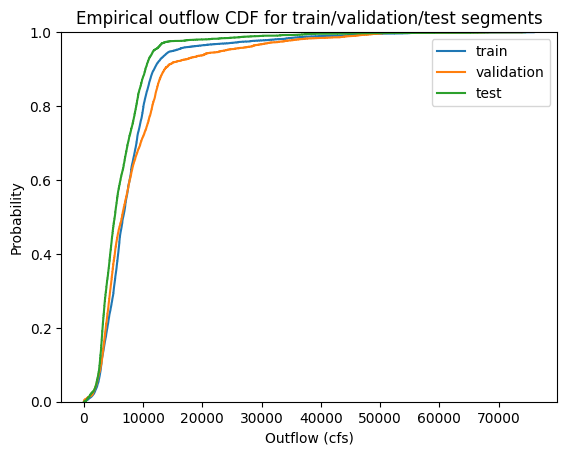

In [7]:
fig, ax = plt.subplots()
ax.ecdf(data_train[:, 1], label='train')
ax.ecdf(data_val[:, 1], label='validation')
ax.ecdf(data_test[:, 1], label='test')
ax.legend()
ax.set_title('Empirical outflow CDF for train/validation/test segments')
ax.set_ylabel('Probability')
ax.set_xlabel('Outflow (cfs)')
# plt.savefig('report/progress_report_1_23_24/figures/outflow_cdfs.png', dpi=300)
plt.show()

### Is the hydrology for the test set significantly drier than the training set?
Test the difference in distribution using a one sided Mann-Whiteney U-test

In [8]:
mannwhitneyu(x=data_train[:, 0], y=data_test[:, 0], alternative='greater').pvalue

np.float64(6.196803448023914e-183)

How about comparing the validation and train set?

In [9]:
mannwhitneyu(x=data_train[:, 0], y=data_val[:, 0], alternative='greater').pvalue

np.float64(0.9978372613828599)

The test set appears to be significantly drier than the trianing set, while the same is not true for the validation set.

## Performance on Rolling and Sliding Windows
In this experiment, we train a model on the first 30 years (validating on the next 10 years for early stopping), and examine R^2 on a rolling window to detect shifts in performance. For simplicity, we use the model architecture from Model 1(a) and tune hyperparameters manually.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from math import floor

from src.data.data_processing import *
from src.data.data_fetching import *
from src.models.model_zoo import *
from src.models.predict_model import *
from src.models.train_model import *
from src.models.hyperparameter_tuning import *

In [11]:
def data_processing(name, transform_type, train_frac=0.75, val_frac=0.25, left='1944-01-01', right='1983-12-31', log_names=[], return_scaler=False):
    """
    Run data processing pipeline.
    Params:
    name -- str, name of reservoir to read
    transform_type -- str, in preprocessing, whether to 'standardize' or 'normalize' the data
    left -- str (YYYY-MM-DD), beginning boundary of time window
    right -- str (YYYY-MM-DD), end boundary of time window
    log_names -- list of column names (str) to take log of before running rest of pipeline. E.g. ['inflow', 'outflow', 'storage']
    return_scaler -- bool, whether or not to return src.data.data_processing.time_scaler() object
    """

    # Read in data, columns are [inflow, outflow, storage]
    df = usbr_fetch_data(name=name, vars=['inflow', 'outflow', 'storage'])
    # Add day of the year (doy) as another column
    df['doy'] = df.index.to_series().dt.dayofyear
    # Select data window
    df = df[left:right].copy()

    # Take log of df columns that are in log_names
    for column_name in df.columns:
        if column_name in log_names:
            df[column_name] = np.log(df[column_name])
        else:
            continue

    # Run data processing pipeline
    pipeline = processing_pipeline(train_frac=train_frac, val_frac=val_frac, test_frac=0, chunk_size=3*365, pad_value=-1, transform_type=transform_type, fill_na_method='mean')
    # Train/val/test tensors of shape (#chunks, chunksize, [inflow, outflow, storage, doy])
    ts_train, ts_val, ts_test = pipeline.process_data(df) 

    # Separate inputs(X) and targets (y)
    # select inflow and doy as input features
    X_train, X_val, X_test = ts_train[:, :, [0, 3]], ts_val[:, :, [0, 3]], ts_test[:, :, [0, 3]]
    # select outflow as target feature
    y_train, y_val, y_test = ts_train[:, :, [1]], ts_val[:, :, [1]], ts_test[:, :, [1]]

    if return_scaler:
        return (X_train, y_train), (X_val, y_val), (X_test, y_test), pipeline.scaler
    else:
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [12]:
def rolling_windows(df, win_size=30, transform_type='standardize'):
    """ 
    Return list of (X, y) tensors corresponding to rolling windows
    Params:
    df -- pandas df (timesteps, features) containing entire time period
    win_size -- int, size of rolling window
    transform_type -- str, in preprocessing, whether to 'standardize' or 'normalize' the data
    Return:
    tensor_list -- list of (X, y) tensors
    right_edge_list -- list of years corresponding to the right edge of each rolling window
    """
    # Get first and last year
    first_year = df.index[0].year
    last_year = df.index[-1].year

    # Create an array of right edges
    # -1 on start to account for using 12/31 instead of 1/1, +1 on end to account for open iterval
    right_edge_list = np.arange(start=first_year+win_size-1, stop=last_year+1)

    # Iterate through rolling windows
    left_edge = first_year # Initialize left edge year
    tensor_list = [] # List to store resulting (X,y) tensors for each window
    for right_edge in right_edge_list:
        left_date = f'{left_edge}-01-01'
        right_date = f'{right_edge}-12-31'
        left_edge += 1

        # Subset current window from df
        df_window = df[left_date:right_date].copy()
        # Process data
        pipeline = processing_pipeline(train_frac=1.0, val_frac=0, test_frac=0, chunk_size=3*365, pad_value=-1, transform_type=transform_type, fill_na_method='mean')
        # Train/val/test tensors of shape (#chunks, chunksize, [inflow, outflow, storage, doy])
        tensor, _, _ = pipeline.process_data(df_window)
        # Separate inputs(X) and targets (y)
        X = tensor[:, :, [0, 3]] # select inflow and doy as input features
        y = tensor[:, :, [1]] # select outflow as target feature
        tensor_list.append((X, y)) # save results
        
    return tensor_list, right_edge_list

In [13]:
def sliding_windows(df, win_size=10, transform_type='standardize'):
    """ 
    Return list of (X, y) tensors corresponding to sliding windows
    Params:
    df -- pandas df (timesteps, features) containing entire time period
    win_size -- int, size of rolling window
    transform_type -- str, in preprocessing, whether to 'standardize' or 'normalize' the data
    Return:
    tensor_list -- list of tuples, (X, y) tensors
    right_edge_list -- list of years corresponding to the right edge of each rolling window
    """
    # Get first and last year
    first_year = df.index[0].year
    last_year = df.index[-1].year

    # Number of windows
    num_windows = int(floor((last_year - first_year + 1) / win_size)) + 1

    # Iterate through rolling windows
    left_edge = first_year # Initialize first left edge year
    right_edge = first_year + win_size - 1 # Initialize first right edge year
    right_edge_list = [] # List to store right edge years
    tensor_list = [] # List to store resulting (X,y) tensors for each window
    for i in range(num_windows):
        right_edge_list.append(right_edge)
        left_date = f'{left_edge}-01-01'
        right_date = f'{right_edge}-12-31'
        left_edge += win_size
        if right_edge + win_size > last_year:
            right_edge = last_year
        else:
            right_edge += win_size
    

        # Subset current window from df
        df_window = df[left_date:right_date].copy()
        # Process data
        pipeline = processing_pipeline(train_frac=1.0, val_frac=0, test_frac=0, chunk_size=3*365, pad_value=-1, transform_type=transform_type, fill_na_method='mean')
        # Train/val/test tensors of shape (#chunks, chunksize, [inflow, outflow, storage, doy])
        tensor, _, _ = pipeline.process_data(df_window)
        # Separate inputs(X) and targets (y)
        X = tensor[:, :, [0, 3]] # select inflow and doy as input features
        y = tensor[:, :, [1]] # select outflow as target feature
        tensor_list.append((X, y)) # save results
    
    # Remove if last window is empty
    if right_edge_list[-2] == right_edge_list[-1]:
        del right_edge_list[-1]
        del tensor_list[-1]
        
    return tensor_list, right_edge_list

In [14]:
def r2_window(model, X, y):
    """
    Evaluate the R2 score for given feature (X) and target (y) tensors 
    """
    # Get predictions
    y_hat= predict(model, X)
    # Flatten and remove padding values
    y_hat, y = flatten_rm_pad(y_hat=y_hat, y=y)
    assert len(y_hat) == len(y)
    # Evaluate R2 score
    r2 = r2_score(y_pred=y_hat, y_true=y)
    return r2

In [15]:
def get_moving_performance(model, name, type, win_size, left='1944-01-01', right='2022-12-31'):
    """
    Return R2 performance on rolling or sliding windows
    Params:
    model -- PyTorch model to make predictions on
    name -- str, name of reservoir to fetch data from
    type -- str, 'rolling' or 'sliding' 
    win_size -- size of moving window
    left / right -- str, define dates for data window
    Returns:
    list of R2 scores for each window, list of years corresponding to right edge
    """
    # Read in data, columns are [inflow, outflow, storage]
    df = usbr_fetch_data(name=name, vars=['inflow', 'outflow', 'storage'])
    # Add day of the year (doy) as another column
    df['doy'] = df.index.to_series().dt.dayofyear
    # Select data window (all data)
    df = df[left:right].copy()

    # Get (X, y) tensors corresponding to moving windows
    if type == 'rolling':
        tensor_list, right_years = rolling_windows(df, win_size=win_size, transform_type='standardize')
    elif type == 'sliding':
        tensor_list, right_years = sliding_windows(df, win_size=win_size, transform_type='standardize')
    else:
        raise Exception('Invalid window type')
    
    # collect R2 scores for each moving window
    R2_list = [] 
    for X, y in tensor_list:
        R2_list.append(r2_window(model, X, y))

    return R2_list, right_years

In [16]:
class initial_model:
    """Train and evaluate a model based on an initial training window for a single reservoir. Use trained model to test moving performance."""
    def __init__(self, name, left_window, right_window, train_frac=0.75, val_frac=0.25, transform_type='standardize', hidden_size1=10, hidden_size2=10, dropout_prob=0.3):
        """ 
        Params:
        name : str, name of reservoir
        left_window: datetime, date of first available data
        right_window: datetime, end point for training/val data window
        train_frac / val_frac: float, proportions of the data to use as train/val. Must add to 1
        transform_type: str, 'standardize' or 'normalize' data during preprocessing
        ** hyperparameters for Model 1a
        """
        self.name = name
        self.left_window = left_window
        self.right_window = right_window
        self.train_frac = train_frac
        self.val_frac = val_frac
        self.isfit = False # track if model has been fitted

        # Data processing
        self.data_result = data_processing(name=name, transform_type=transform_type, left=left_window, right=right_window, train_frac=train_frac, val_frac=val_frac)
        # Create PyTorch dataset and dataloader
        dataset_train, dataset_val = (TensorDataset(*self.data_result[0]), TensorDataset(*self.data_result[1]))
        # shuffle = False to preserve time order
        self.dataloader_train, self.dataloader_val = (DataLoader(dataset_train, batch_size=1, shuffle=False), 
                                                            DataLoader(dataset_val, batch_size=1, shuffle=False))
        
        # Instantiate model
        input_size = 2
        hidden_size1 = hidden_size1
        hidden_size2 = hidden_size2
        output_size = 1
        dropout_prob = dropout_prob
        num_layers = 1
        torch.manual_seed(0)
        self.model = LSTMModel1_opt(input_size=input_size, hidden_size1=hidden_size1, 
                                    hidden_size2=hidden_size2, output_size=output_size, num_layers=num_layers, dropout_prob=dropout_prob)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

        # Save moving performance results
        self.R2_rolling = None
        self.R2_sliding = None
        return
    
    def train_eval(self, plot=True):
        """Train model and evaluate performance. If plot is true, plot training curve and pred vs obs"""
        self.isfit = True
        # Run training loop
        train_losses, val_losses = training_loop(model=self.model, criterion=self.criterion, optimizer=self.optimizer, 
                                                patience=10, dataloader_train=self.dataloader_train, 
                                                dataloader_val=self.dataloader_val, epochs=1000)
        # Evaluate performance
        # Get predictions
        y_hat_train, y_hat_val= predict(self.model, self.data_result[0][0]), predict(self.model, self.data_result[1][0])
        # Flatten and remove padding values
        y_hat_train, y_train = flatten_rm_pad(y_hat=y_hat_train, y=self.data_result[0][1])
        y_hat_val, y_val = flatten_rm_pad(y_hat=y_hat_val, y=self.data_result[1][1])
        # Find and save R2 metrics
        self.r2_train = r2_score(y_pred=y_hat_train, y_true=y_train)
        self.r2_val = r2_score(y_pred=y_hat_val, y_true=y_val)
        print(f"Training R2: {self.r2_train}, Validation R2: {self.r2_val}")

        if plot:
            plt.figure()
            plot_train_val(train_losses=train_losses, val_losses=val_losses)
            plt.show()
            plt.clf()
            plt.figure()
            # Concat train and val predictions, check dimensions with datetime index
            y_hat, y = torch.cat((y_hat_train, y_hat_val)), torch.cat((y_train, y_val))
            len(y_hat) == len(y)
            plt.plot(y, label='observed')
            plt.plot(y_hat, label='predicted')
            plt.legend()
            plt.show()
        return
    
    def plot_moving_performance(self, type, win_size, ax, text_pos=0.6):
        """
        Plot moving performance.
        Params:
        type: str, 'rolling' or 'sliding'
        win_size: int, number of years in moving window
        ax: matplotlib axes to plot on
        text_pos: y-axis position (R2 value) to label train/val r2 score text
        """
        assert self.isfit == True
        # Get moving performance and corresponding right window edges
        if type == 'rolling':
            self.R2_rolling, self.rolling_years = get_moving_performance(model=self.model, name=self.name, type='rolling', win_size=win_size, left=self.left_window)

            ax.plot(self.rolling_years, self.R2_rolling)
            # Label training and validation window
            self.data_size = pd.to_datetime(self.right_window).year - pd.to_datetime(self.left_window).year + 1
            self.train_size = int(round(self.data_size * self.train_frac))
            ax.axvline(x=pd.to_datetime(self.left_window).year + self.train_size -1, linestyle='--', color='black', alpha=0.8) #-1 to account for right edges being 12/31 instead of 1/1
            ax.text(x=pd.to_datetime(self.left_window).year + self.train_size-0.9, y=text_pos, s=f'Train: $R^2={round(self.r2_train, 2)}$ ', ha='right', va='top', size='small', rotation=90)
            ax.axvline(x=pd.to_datetime(self.right_window).year, linestyle='--', color='black', alpha=0.8) #-1 to account for right edges being 12/31 instead of 1/1
            ax.text(x=pd.to_datetime(self.right_window).year, y=text_pos, s=f'Val: $R^2={round(self.r2_val, 2)}$ ', ha='right', va='top', size='small', rotation=90)
            ax.set_ylabel('$R^2$')
            ax.set_xlabel('Year (right edge)')
            ax.set_title('$R^2$ score on rolling window')
            
        elif type == 'sliding':
            self.R2_sliding, self.sliding_years = get_moving_performance(model=self.model, name=self.name, type='sliding', win_size=win_size, left=self.left_window)
                
            ax.plot(self.sliding_years, self.R2_sliding, marker='o')
            # Label training and validation window
            self.data_size = pd.to_datetime(self.right_window).year - pd.to_datetime(self.left_window).year + 1
            self.train_size = int(round(self.data_size * self.train_frac))
            ax.axvline(x=pd.to_datetime(self.left_window).year + self.train_size -1, linestyle='--', color='black', alpha=0.8) #-1 to account for right edges being 12/31 instead of 1/1
            ax.text(x=pd.to_datetime(self.left_window).year + self.train_size-0.9, y=text_pos, s=f'Train: $R^2={round(self.r2_train, 2)}$ ', ha='right', va='top', size='small', rotation=90)
            ax.axvline(x=pd.to_datetime(self.right_window).year, linestyle='--', color='black', alpha=0.8) #-1 to account for right edges being 12/31 instead of 1/1
            ax.text(x=pd.to_datetime(self.right_window).year, y=text_pos, s=f'Val: $R^2={round(self.r2_val, 2)}$ ', ha='right', va='top', size='small', rotation=90)
            ax.set_ylabel('$R^2$')
            ax.set_xlabel('Year (right edge)')
            ax.set_title('$R^2$ score on sliding window')
        
        

### Shasta: Train a model using initial training window

In [17]:
# First date of available data (first date after leading na's)
usbr_fetch_data(name='Shasta', vars=['inflow', 'outflow', 'storage']).isna().idxmin().max()

Timestamp('1943-12-31 08:00:00')

Training epochs:  18%|█▊        | 176/1000 [00:06<00:30, 27.11it/s]

Training R2: 0.7138759144019478, Validation R2: 0.621346802791297


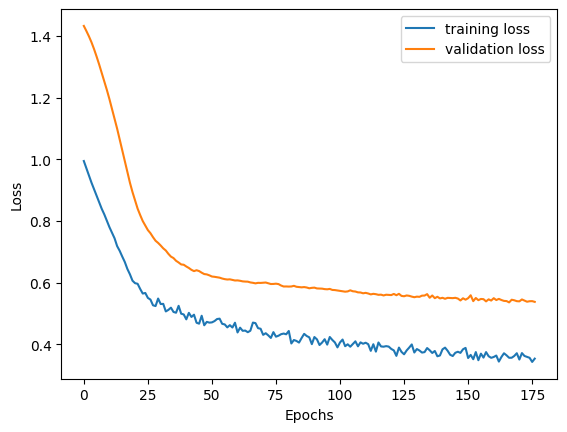

<Figure size 640x480 with 0 Axes>

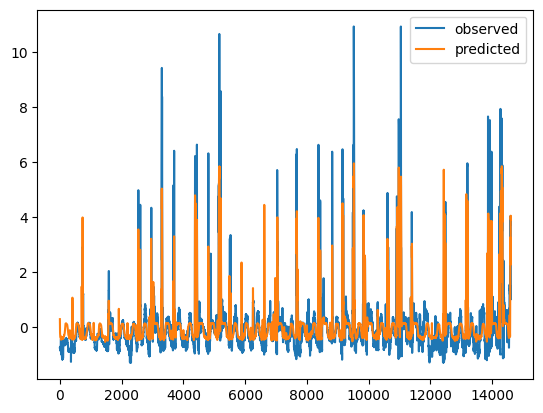

In [18]:
shasta_model = initial_model(name='Shasta', left_window='1944-01-01', right_window='1983-12-31', train_frac=0.75, val_frac=0.25)
shasta_model.train_eval(plot=True)

### Evaluate performance on a rolling window

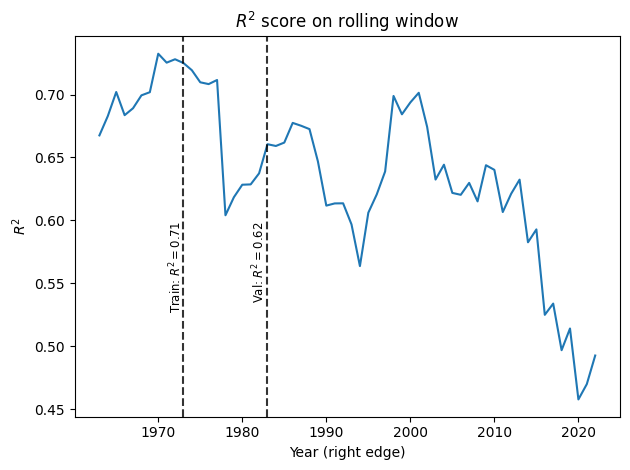

In [19]:
fig, ax = plt.subplots()
shasta_model.plot_moving_performance(type='rolling', win_size=20, ax=ax)
plt.tight_layout()
plt.show()

### Evaluate performance on sliding windows
Rolling windows may be make it difficult to discern where the influence of the training set ends.

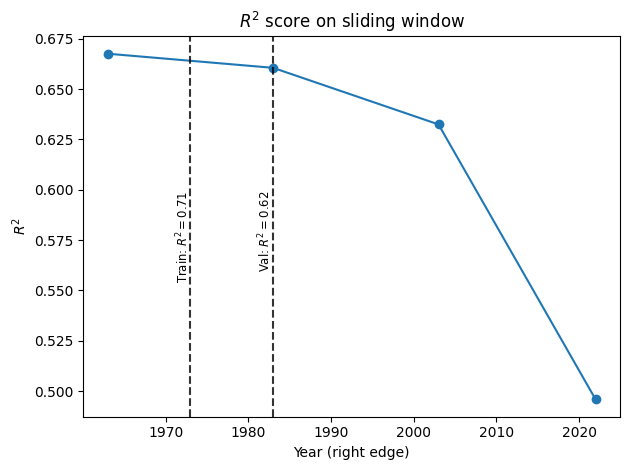

In [20]:
fig, ax = plt.subplots()
shasta_model.plot_moving_performance(type='sliding', win_size=20, ax=ax)
plt.tight_layout()
plt.show()

### Side experiment: What if we take the log of the original data (inflow/outflow)?

In [21]:
# Run data processing pipeline
left_window = '1944-01-01'
right_window = '1983-12-31'
train_frac = 0.75
val_frac = 0.25
result_log = data_processing(name='Shasta', transform_type='standardize', left=left_window, 
                             right=right_window, train_frac=train_frac, val_frac=val_frac,
                             log_names=['inflow', 'outflow', 'storage'], return_scaler=True)
# Create PyTorch dataset and dataloader
dataset_train_log, dataset_val_log = (TensorDataset(*result_log[0]), TensorDataset(*result_log[1]))
scaler = result_log[-1]
# shuffle = False to preserve time order
dataloader_train_log, dataloader_val_log = (DataLoader(dataset_train_log, batch_size=1, shuffle=False), 
                                                    DataLoader(dataset_val_log, batch_size=1, shuffle=False))

In [22]:
# Instantiate model
input_size = 2
hidden_size1 = 25
hidden_size2 = 20
output_size = 1
dropout_prob = 0.1
num_layers = 1

torch.manual_seed(0)
model_log = LSTMModel1_opt(input_size=input_size, hidden_size1=hidden_size1, 
                            hidden_size2=hidden_size2, output_size=output_size, num_layers=num_layers, dropout_prob=dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_log.parameters(), lr=0.001)

Training epochs:   4%|▎         | 36/1000 [00:01<00:39, 24.47it/s]


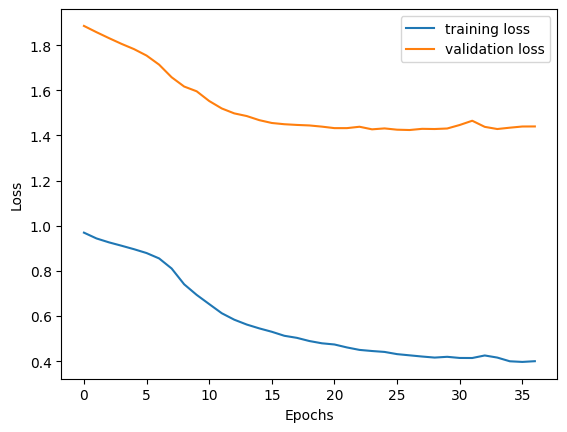

In [23]:
# Run training loop
train_losses_log, val_losses_log = training_loop(model=model_log, criterion=criterion, optimizer=optimizer, 
                                        patience=10, dataloader_train=dataloader_train_log, 
                                        dataloader_val=dataloader_val_log, epochs=1000)
# Plot train/validation plot
plot_train_val(train_losses=train_losses_log, val_losses=val_losses_log)
plt.show()

C:\Users\mattc\AppData\Local\Temp\ipykernel_20316\1704223713.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y_hat_train_log, y_train_log = np.exp(y_hat_train_log), np.exp(y_train_log)
C:\Users\mattc\AppData\Local\Temp\ipykernel_20316\1704223713.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y_hat_val_log, y_val_log = np.exp(y_hat_val_log), np.exp(y_val_log)


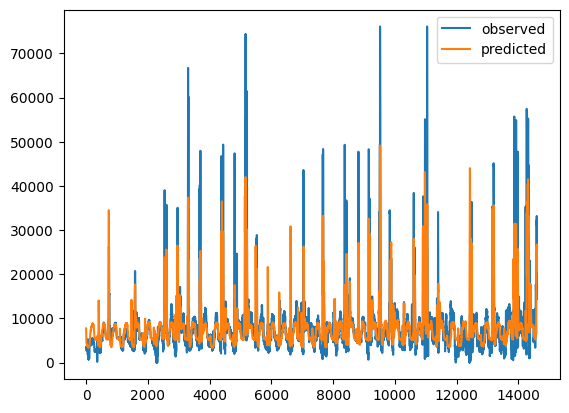

In [ ]:
# Training and validation performance

# Get predictions
y_hat_train_log, y_hat_val_log= predict(model_log, result_log[0][0]), predict(model_log, result_log[1][0])

# Flatten and remove padding values
y_hat_train_log, y_train_log = flatten_rm_pad(y_hat=y_hat_train_log, y=result_log[0][1])
y_hat_val_log, y_val_log = flatten_rm_pad(y_hat=y_hat_val_log, y=result_log[1][1])

# Undo scaling
y_hat_train_log, y_train_log = y_hat_train_log * scaler.std[0, 1] + scaler.mean[0, 1], y_train_log * scaler.std[0, 1] + scaler.mean[0, 1]
y_hat_val_log, y_val_log = y_hat_val_log * scaler.std[0, 1] + scaler.mean[0, 1], y_val_log * scaler.std[0, 1] + scaler.mean[0, 1]

# Undo logarithm
y_hat_train_log, y_train_log = np.exp(y_hat_train_log), np.exp(y_train_log)
y_hat_val_log, y_val_log = np.exp(y_hat_val_log), np.exp(y_val_log)

# Find R2 metrics
r2_train_log = r2_score(y_pred=y_hat_train_log, y_true=y_train_log)
r2_val_log = r2_score(y_pred=y_hat_val_log, y_true=y_val_log)

# Plot
# Concat results, check dimensions with datetime index
y_hat_log, y_log = torch.cat((y_hat_train_log, y_hat_val_log)), torch.cat((y_train_log, y_val_log))
len(y_hat_log) == len(y_log)
plt.plot(y_log, label='observed')
plt.plot(y_hat_log, label='predicted')
plt.legend()
plt.show()

In [28]:
r2_train_log, r2_val_log

(0.6838264395883193, 0.5924283470316594)

## Do other reservoirs follow the same pattern?

### Train model for Folsom

<Axes: >

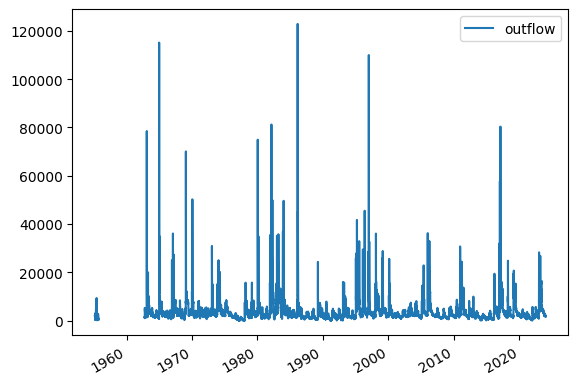

In [29]:
# plot observed outflow (not early NaN)
usbr_fetch_data(name='Folsom', vars=['outflow']).plot()

In [30]:
# First date after leading na's
usbr_fetch_data(name='Folsom', vars=['inflow', 'outflow', 'storage'])['1960-01-01':'2020-12-31'].isna().idxmin().max()

Timestamp('1962-10-01 08:00:00')

Training epochs:  12%|█▏        | 117/1000 [00:04<00:33, 26.02it/s]

Training R2: 0.8331811461997507, Validation R2: 0.7824055407545165


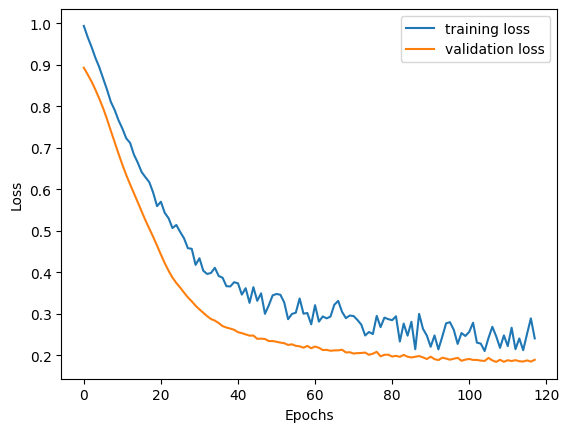

<Figure size 640x480 with 0 Axes>

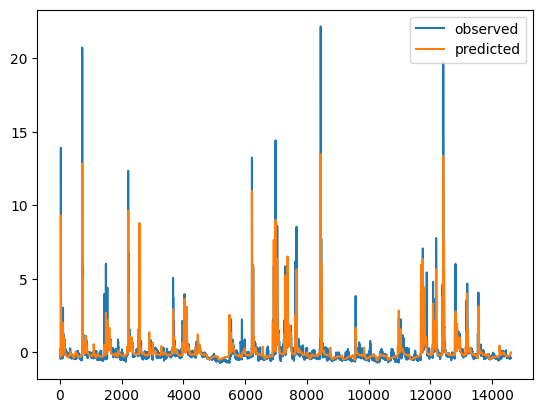

In [31]:
folsom_model = initial_model(name='Folsom', left_window='1963-01-01', right_window='2002-12-31')
folsom_model.train_eval(plot=True)

### Train model for New Melones

In [32]:
# First date after leading na's
usbr_fetch_data(name='New_Melones', vars=['inflow', 'outflow', 'storage']).isna().idxmin().max()

Timestamp('1979-06-30 08:00:00')

Training epochs:  13%|█▎        | 132/1000 [00:04<00:30, 28.21it/s]

Training R2: 0.5457263855974894, Validation R2: 0.45114099681580555


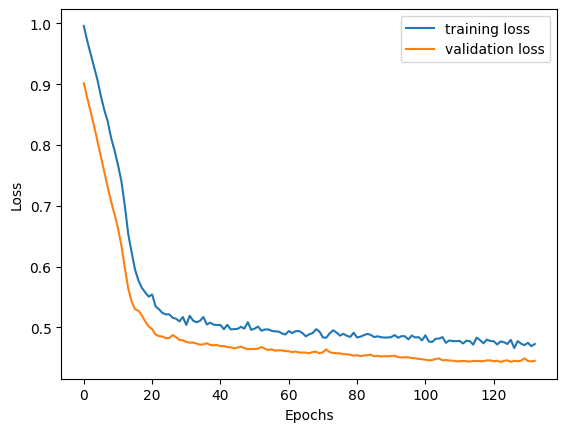

<Figure size 640x480 with 0 Axes>

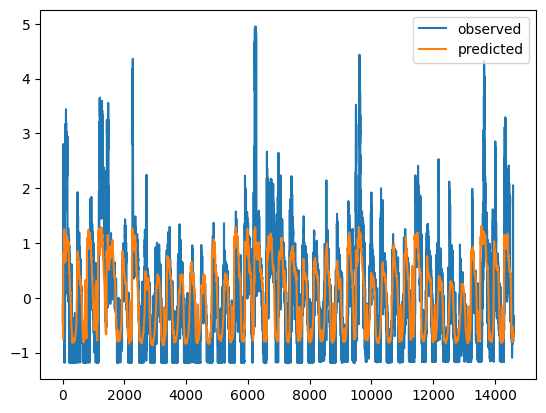

In [33]:
melones_model = initial_model(name='New_Melones', left_window='1980-01-01', right_window='2019-12-31')
melones_model.train_eval(plot=True)

### Train model for Trinity

In [34]:
# First date after leading na's
usbr_fetch_data(name='Trinity', vars=['inflow', 'outflow', 'storage']).isna().idxmin().max()

Timestamp('1962-11-01 08:00:00')

Training epochs:   6%|▌         | 55/1000 [00:01<00:33, 28.56it/s]

Training R2: 0.3171329110833224, Validation R2: 0.2046709291900739


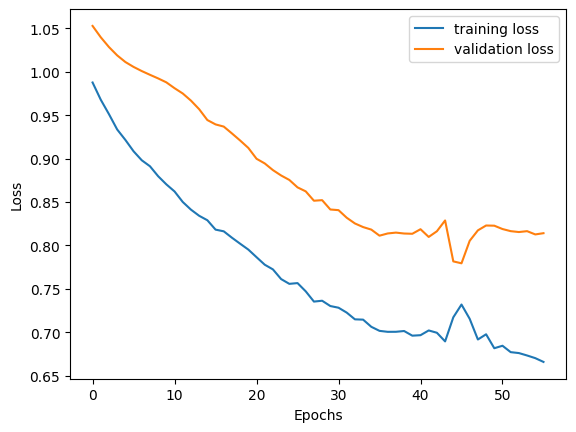

<Figure size 640x480 with 0 Axes>

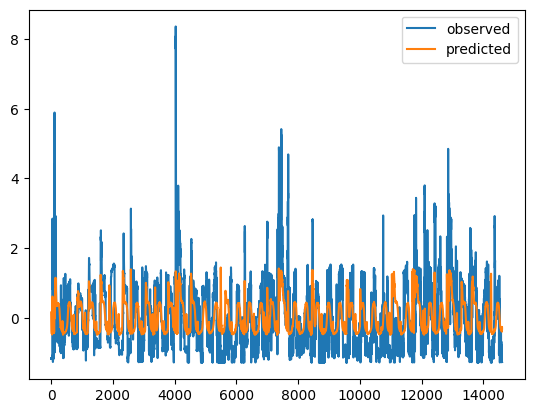

In [35]:
trinity_model = initial_model(name='Trinity', left_window='1963-01-01', right_window='2002-12-31')
trinity_model.train_eval(plot=True)

The models for Trinity and New Melones perform poorly, especially Trinity. By plotting inflow vs outflow, it is clear that outflow is not as influenced by inflow in these reservoirs compared to Folsom and Shasta (evident in how peak flows correspond usually with peak releases).

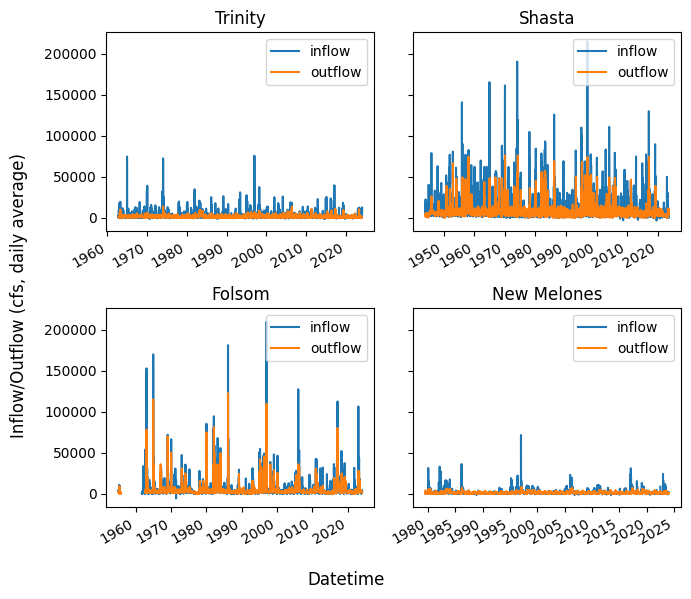

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(7, 6))
usbr_fetch_data(name='Trinity', vars=['inflow', 'outflow']).plot(ax=axes[0, 0])
usbr_fetch_data(name='Shasta', vars=['inflow', 'outflow']).plot(ax=axes[0, 1])
usbr_fetch_data(name='Folsom', vars=['inflow', 'outflow']).plot(ax=axes[1, 0])
usbr_fetch_data(name='New_Melones', vars=['inflow', 'outflow']).plot(ax=axes[1, 1])
axes[0, 0].set_title('Trinity')
axes[0, 1].set_title('Shasta')
axes[1, 0].set_title('Folsom')
axes[1, 1].set_title('New Melones')
fig.supxlabel('Datetime')
fig.supylabel('Inflow/Outflow (cfs, daily average)')
plt.tight_layout()
plt.show()

### Performance on rolling window

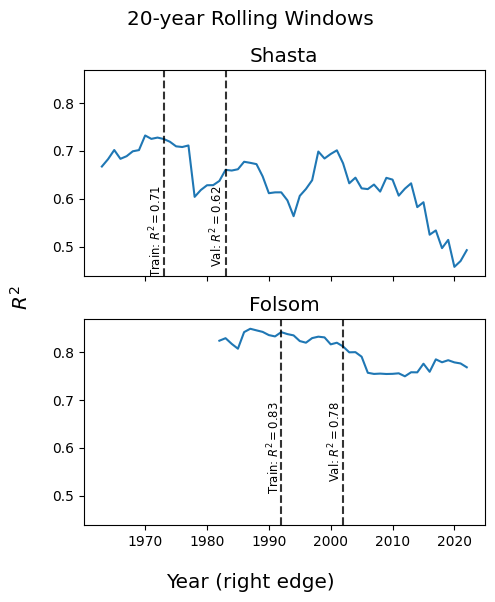

In [47]:
# Plot result
fig, axes = plt.subplots(ncols=1, nrows=2, sharey=True, sharex=True, figsize=(5, 6))
shasta_model.plot_moving_performance(type='rolling', win_size=20, text_pos=0.63, ax=axes[0])
folsom_model.plot_moving_performance(type='rolling', win_size=20, text_pos=0.7, ax=axes[1])
axes[0].set_title('Shasta', size='x-large')
axes[1].set_title('Folsom', size='x-large')

for ax in axes.reshape(-1):
    ax.set_xlabel("")
    ax.set_ylabel("")

fig.supxlabel('Year (right edge)', size='x-large')
fig.supylabel('$R^2$', size='x-large')
fig.suptitle('20-year Rolling Windows', size='x-large')
plt.tight_layout()
plt.savefig('report/drafting/8_15_2025/Figures/rolling_window.png', dpi=300)
plt.show()

### Performance on sliding window

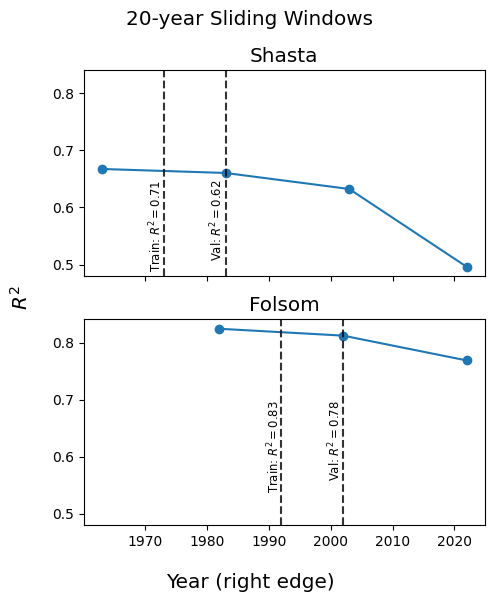

In [50]:
# Plot result
fig, axes = plt.subplots(ncols=1, nrows=2, sharey=True, sharex=True, figsize=(5, 6))
shasta_model.plot_moving_performance(type='sliding', win_size=20, text_pos=0.65, ax=axes[0])
folsom_model.plot_moving_performance(type='sliding', win_size=20, text_pos=0.7, ax=axes[1])

axes[0].set_title('Shasta', size='x-large')
axes[1].set_title('Folsom', size='x-large')

for ax in axes.reshape(-1):
    ax.set_xlabel("")
    ax.set_ylabel("")

fig.supxlabel('Year (right edge)', size='x-large')
fig.supylabel('$R^2$', size='x-large')
fig.suptitle('20-year Sliding Windows', size='x-large')
plt.tight_layout()
plt.savefig('report/drafting/8_15_2025/Figures/sliding_window.png', dpi=300)
plt.show()